In [1]:
# -*- coding: utf-8 -*-
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
import itertools

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load and prepare the data
data = np.load('./xwz_set.npz')
print(data.keys())
z_w_var = data['z_w_var']
z_x_mean = data['z_x_mean']
x = data['x']
w = data['w']
z_x_var = data['z_x_var']
z_xw_mean = data['z_xw_mean']
z_xw_var = data['z_xw_var']
label = data['label']
info = data['info']
z_w_mean = data['z_w_mean']
data.close()
# Get some information out of the VAE
D_z = z_x_mean.shape[1] # Latent space dimension
num_sample = label.shape[0] # Number of samples
print(info)

# samples an index for a given PoI 
def sample_idx_from_label(poi):
    p_ = np.float64(np.int32(label) == np.int32(poi))
    p = p_ / np.sum(p_)
    return np.random.choice(np.arange(num_sample), p=p)


['z_w_var', 'z_x_mean', 'x', 'w', 'z_x_var', 'z_xw_mean', 'z_xw_var', 'label', 'info', 'z_w_mean']
label 0: Red and Round; label 1: Red and Cube; label 2: Green and Round
Trained on 300 epochs with Adam


In [3]:
# The JMVAE environment

# HOWTO
#tmp = jmvae_gym('my_gym', 'x')
#tmp.sample_env()
#print(tmp.environment)
#tmp.step(0)
#print(tmp.environment)

class jmvae_gym:
    def __init__(self, name, modality):
        self.name = name
        # Quantities
        self.statistics = 2 # mu and sigma
        self.poi = 3 # number of objects
        self.D_z = D_z # latent space dimension of the VAE
        self.D_z_full = D_z * self.statistics # full latent space dimension of the VAE
        self.observation_space = self.D_z * self.statistics * self.poi # statistics for all objects
        self.action_space = 3 # choose one of the objects ( the additional action for quitting the game is added later)
        self.modality_space = 2 # x and w
        self.mean_idx = np.arange(0,self.D_z_full,self.statistics) # the first mean occurs at index 0
        self.var_idx = np.arange(1,self.D_z_full,self.statistics) # the first variance occurs at index 1
        # Environment
        self.environment = np.zeros((self.poi, self.D_z * self.statistics), dtype=np.float32)
        self.uninformed_mean = np.float32(0.0)
        self.uninformed_var = np.float32(20.)
        if not (modality == 'x' or modality == 'w'):
            raise Exception('modality needs to be x or w')
        else:
            self.modality = modality
        self.xw_seen = np.zeros((self.action_space, self.modality_space), dtype=np.bool)
        self.sample_permutations = ["123", "132", "213", "231", "312", "321"] # all permutations of PoI arrangements
        self.current_permutation_idx = np.zeros((self.poi,), dtype=np.int)
        # step information
        self.done = False

    def _sample_seen(self):
        # return a vector of already seen PoIs
        return np.random.rand(self.action_space,self.modality_space) > .5

    def _encode(self, poi, modalities):
        environment = np.zeros((self.D_z * self.statistics), dtype=np.float32) # (mu_1, sigma_1), ..., (mu_Dz, sigma_Dz)
        sample_idx = sample_idx_from_label(poi)
        if modalities == 'x':
            environment[0], environment[1] = z_x_mean[sample_idx, 0], z_x_var[sample_idx, 0]
            environment[2], environment[3] = z_x_mean[sample_idx, 1], z_x_var[sample_idx, 1]
        elif modalities == 'w':
            environment[0], environment[1] = z_w_mean[sample_idx, 0], z_w_var[sample_idx, 0]
            environment[2], environment[3] = z_w_mean[sample_idx, 1], z_w_var[sample_idx, 1]
        elif modalities == 'xw':
            environment[0], environment[1] = z_xw_mean[sample_idx, 0], z_xw_var[sample_idx, 0]
            environment[2], environment[3] = z_xw_mean[sample_idx, 1], z_xw_var[sample_idx, 1]
        return environment

    def sample_env(self):
        self.done = False
        # sample the already seen PoIs
        self.xw_seen = self._sample_seen()
        while np.all(self.xw_seen) or np.all(~self.xw_seen):
            self.xw_seen = self._sample_seen()
        # Sample the permutation (usage TBD)
        permutation_string = np.random.choice(self.sample_permutations)
        # Do the encoding wrt. the permutation
        for idx_poi in range(self.action_space):
            current_poi = idx_poi
            self.current_permutation_idx[idx_poi] = np.int(permutation_string[idx_poi]) - np.int(1)
            current_xw_seen = self.xw_seen[current_poi,:]
            if np.all(current_xw_seen): # sample x and w 
                self.environment[current_poi,:] = self._encode(current_poi, 'xw')
            elif current_xw_seen[0]: # sample x
                self.environment[current_poi,:] = self._encode(current_poi, 'x')
            elif current_xw_seen[1]: # sample w
                self.environment[current_poi,:] = self._encode(current_poi, 'w')
            else: # nothing seen yet
                self.environment[current_poi,0] = self.uninformed_mean # mu_1
                self.environment[current_poi,1] = self.uninformed_var # sigma_1
                self.environment[current_poi,2] = self.uninformed_mean # mu_2
                self.environment[current_poi,3] = self.uninformed_var # sigma_2

    def step(self, action):
        if action == self.action_space: # terminating condition
            return self.environment, 0, True, {}
        if action > self.action_space and action < 0:
            raise Exception('action needs to be within the action space')
        next_environment = np.copy(self.environment) # local copy
        current_next_environment = np.copy(next_environment[action,:])
        current_xw_seen = np.copy(self.xw_seen[action,:])
        # Choose the proper change in the env. for the choosen action
        if self.modality == 'x':
            if np.all(~current_xw_seen) or (current_xw_seen[0] and ~current_xw_seen[1]): # haven't seen anything yet or just x
                current_next_environment = self._encode(action, 'x')
            elif np.all(current_xw_seen) or (~current_xw_seen[0] and current_xw_seen[1]): # haven't seen everything or just w
                current_next_environment = self._encode(action, 'xw')
            else:
                raise Exception('set x went wrong')
            current_xw_seen[0] = True
        elif self.modality == 'w':
            if np.all(~current_xw_seen) or (~current_xw_seen[0] and current_xw_seen[1]): # haven't seen anything yet or just w
                current_next_environment = self._encode(action, 'w')
            elif np.all(current_xw_seen) or (current_xw_seen[0] and ~current_xw_seen[1]): # haven't seen everything or just x
                current_next_environment = self._encode(action, 'xw')
            else:
                raise Exception('set w went wrong')
            current_xw_seen[1] = True
        else:
            raise Exception('I do not have this modality!')
        # assign the new envronment
        next_environment[action,:] = np.copy(current_next_environment)
        self.xw_seen[action,:] = np.copy(current_xw_seen)
        # reward
        sigma_old = np.linalg.norm(np.sqrt(self.environment[action, self.var_idx]), 2)
        sigma_new = np.linalg.norm(np.sqrt(next_environment[action, self.var_idx]), 2)
        information_old = 1 / sigma_old
        information_new = 1 / sigma_new
        information_tmp = information_new - information_old
        if information_tmp < 0.01: # we just have to shift the expected average reward a little bit
            reward = -1.
        else:
            reward = information_tmp # .1 / information_tmp
        # done?
        if np.all(self.xw_seen[:,0]) and self.modality == 'x' or np.all(self.xw_seen[:,1]) and self.modality == 'w':
            self.done = True
        self.environment = next_environment
        return next_environment, reward, self.done, {}


In [4]:
# DQN and DDQN algorithms        
class DQNAgent:
    def __init__(self, state_size, action_size, eval_memory_len = 5000):
        self.state_size = state_size
        self.action_size = action_size
        self.eval_memory_len = eval_memory_len
        self.memory = deque(maxlen=2000)
        self.memory_longterm = deque(maxlen=self.eval_memory_len)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _compile_model(self, model):
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model
        
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        return self._compile_model(model)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        self.memory_longterm.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

class DDQNAgent(DQNAgent):
    def __init__(self, state_size, action_size, eval_memory_len = 5000):
        super(DDQNAgent, self).__init__(state_size, action_size, eval_memory_len)
        self.target_model = self._build_model()
        self.update_target_model()

    def _huber_loss(self, target, prediction):
        error = prediction - target
        return K.mean(K.sqrt(1+K.square(error))-1, axis=-1)

    def _compile_model(self, model):
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                t = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * np.amax(t)
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [5]:
# Training function
        
# Printing debug information: Change to 'if True' to turn on
def printd(string):
    if False:
        print(string)

def train(env_name = 'jmvae_gym', modality = 'x', EPISODES = 5000, use_ddqn = True):
    # print(env.environment)
    env = jmvae_gym(env_name, modality)
    state_size = env.observation_space
    action_size = env.action_space + 1 # choosing a PoI plus terminating action
    if use_ddqn:
        agent = DDQNAgent(state_size, action_size, EPISODES)
    else:
        agent = DQNAgent(state_size, action_size, EPISODES)
    done = False
    batch_size = 64
    
    # Sampled environments for evaluation
    num_random_states = 512
    random_env = num_random_states*[None]
    random_states_xw_seen = num_random_states*[None]
    random_states_rewards = np.zeros((EPISODES, num_random_states))
    for idx in range(num_random_states):
        env.sample_env()
        random_states_xw_seen[idx] = np.copy(env.xw_seen)
        random_env[idx] = np.copy(env.environment)

    # Training
    for e in range(EPISODES):
        env.sample_env()
        state = np.reshape(env.environment, [1, state_size])
        for time in range(20):
            printd("++++++++++++++++++++++++++++")
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            printd("action: " + str(action))
            printd("reward: " + str(reward))
            next_state = np.reshape(next_state, [1, state_size])
            printd("state:")
            printd(state)
            printd("next_state:")
            printd(next_state)
            printd(env.xw_seen)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                # Evaluation
                for idx in range(num_random_states):
                    env.xw_seen = random_states_xw_seen[idx]
                    env.environment = random_env[idx]
                    random_state = np.reshape(env.environment, [1, state_size])
                    _, random_states_rewards[e, idx], _, _ = env.step(agent.act(random_state))
                # Print average reward
                if np.mod(e,10) == 0:
                    print("Avg. reward: " + str(np.sum(random_states_rewards[e, :])))
                # Update the model
                if use_ddqn:
                    agent.update_target_model()
                print("episode: {}/{}, #actions: {}, e: {:.2}"
                      .format(e, EPISODES, time + 1, agent.epsilon))
                printd("----------------------------------------------------------------")
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
    return env, agent, random_states_rewards


In [6]:
EPISODES = 1000
env_x, agent_x, avg_reward_x = train('jmvae_gym_x', 'x', EPISODES = EPISODES, use_ddqn = True)
env_w, agent_w, avg_reward_w = train('jmvae_gym_w', 'w', EPISODES = EPISODES, use_ddqn = True)

Avg. reward: -125.88692621836907
episode: 0/1000, #actions: 1, e: 1.0
episode: 1/1000, #actions: 1, e: 1.0
episode: 2/1000, #actions: 3, e: 1.0
episode: 3/1000, #actions: 1, e: 1.0
episode: 4/1000, #actions: 2, e: 1.0
episode: 5/1000, #actions: 1, e: 1.0
episode: 6/1000, #actions: 4, e: 1.0
episode: 7/1000, #actions: 1, e: 1.0
episode: 8/1000, #actions: 1, e: 1.0
episode: 9/1000, #actions: 1, e: 1.0
Avg. reward: -160.23366113633173
episode: 10/1000, #actions: 1, e: 1.0
episode: 11/1000, #actions: 2, e: 1.0
episode: 12/1000, #actions: 2, e: 1.0
episode: 13/1000, #actions: 2, e: 1.0
episode: 14/1000, #actions: 1, e: 1.0
episode: 15/1000, #actions: 1, e: 1.0
episode: 16/1000, #actions: 2, e: 1.0
episode: 17/1000, #actions: 2, e: 1.0
episode: 18/1000, #actions: 4, e: 1.0
episode: 19/1000, #actions: 2, e: 1.0
Avg. reward: -137.6930912376698
episode: 20/1000, #actions: 1, e: 1.0
episode: 21/1000, #actions: 1, e: 1.0
episode: 22/1000, #actions: 2, e: 1.0
episode: 23/1000, #actions: 2, e: 1.0


episode: 193/1000, #actions: 2, e: 0.48
episode: 194/1000, #actions: 2, e: 0.48
episode: 195/1000, #actions: 1, e: 0.48
episode: 196/1000, #actions: 2, e: 0.48
episode: 197/1000, #actions: 1, e: 0.48
episode: 198/1000, #actions: 1, e: 0.48
episode: 199/1000, #actions: 2, e: 0.48
Avg. reward: 32.97070847652326
episode: 200/1000, #actions: 4, e: 0.47
episode: 201/1000, #actions: 2, e: 0.47
episode: 202/1000, #actions: 4, e: 0.46
episode: 203/1000, #actions: 3, e: 0.46
episode: 204/1000, #actions: 1, e: 0.46
episode: 205/1000, #actions: 1, e: 0.46
episode: 206/1000, #actions: 1, e: 0.46
episode: 207/1000, #actions: 1, e: 0.46
episode: 208/1000, #actions: 2, e: 0.45
episode: 209/1000, #actions: 2, e: 0.45
Avg. reward: 22.335363811589204
episode: 210/1000, #actions: 1, e: 0.45
episode: 211/1000, #actions: 2, e: 0.45
episode: 212/1000, #actions: 1, e: 0.45
episode: 213/1000, #actions: 1, e: 0.45
episode: 214/1000, #actions: 1, e: 0.45
episode: 215/1000, #actions: 4, e: 0.44
episode: 216/1000

episode: 384/1000, #actions: 6, e: 0.22
episode: 385/1000, #actions: 1, e: 0.22
episode: 386/1000, #actions: 1, e: 0.22
episode: 387/1000, #actions: 2, e: 0.22
episode: 388/1000, #actions: 2, e: 0.22
episode: 389/1000, #actions: 3, e: 0.22
Avg. reward: 124.71098612075136
episode: 390/1000, #actions: 1, e: 0.22
episode: 391/1000, #actions: 2, e: 0.22
episode: 392/1000, #actions: 1, e: 0.22
episode: 393/1000, #actions: 1, e: 0.22
episode: 394/1000, #actions: 1, e: 0.22
episode: 395/1000, #actions: 1, e: 0.22
episode: 396/1000, #actions: 1, e: 0.22
episode: 397/1000, #actions: 1, e: 0.22
episode: 398/1000, #actions: 1, e: 0.22
episode: 399/1000, #actions: 1, e: 0.22
Avg. reward: 118.31533446653026
episode: 400/1000, #actions: 1, e: 0.22
episode: 401/1000, #actions: 1, e: 0.22
episode: 402/1000, #actions: 2, e: 0.21
episode: 403/1000, #actions: 1, e: 0.21
episode: 404/1000, #actions: 2, e: 0.21
episode: 405/1000, #actions: 1, e: 0.21
episode: 406/1000, #actions: 3, e: 0.21
episode: 407/100

episode: 575/1000, #actions: 1, e: 0.12
episode: 576/1000, #actions: 3, e: 0.12
episode: 577/1000, #actions: 2, e: 0.12
episode: 578/1000, #actions: 3, e: 0.12
episode: 579/1000, #actions: 2, e: 0.12
Avg. reward: 167.72418360852583
episode: 580/1000, #actions: 2, e: 0.12
episode: 581/1000, #actions: 3, e: 0.11
episode: 582/1000, #actions: 3, e: 0.11
episode: 583/1000, #actions: 2, e: 0.11
episode: 584/1000, #actions: 1, e: 0.11
episode: 585/1000, #actions: 1, e: 0.11
episode: 586/1000, #actions: 2, e: 0.11
episode: 587/1000, #actions: 1, e: 0.11
episode: 588/1000, #actions: 1, e: 0.11
episode: 589/1000, #actions: 1, e: 0.11
Avg. reward: 174.84301891369097
episode: 590/1000, #actions: 1, e: 0.11
episode: 591/1000, #actions: 3, e: 0.11
episode: 592/1000, #actions: 2, e: 0.11
episode: 593/1000, #actions: 1, e: 0.11
episode: 594/1000, #actions: 1, e: 0.11
episode: 595/1000, #actions: 1, e: 0.11
episode: 596/1000, #actions: 2, e: 0.11
episode: 597/1000, #actions: 2, e: 0.11
episode: 598/100

episode: 762/1000, #actions: 2, e: 0.064
episode: 763/1000, #actions: 3, e: 0.064
episode: 764/1000, #actions: 1, e: 0.064
episode: 765/1000, #actions: 1, e: 0.064
episode: 766/1000, #actions: 1, e: 0.064
episode: 767/1000, #actions: 2, e: 0.063
episode: 768/1000, #actions: 1, e: 0.063
episode: 769/1000, #actions: 1, e: 0.063
Avg. reward: 163.59879084724975
episode: 770/1000, #actions: 3, e: 0.063
episode: 771/1000, #actions: 1, e: 0.063
episode: 772/1000, #actions: 2, e: 0.063
episode: 773/1000, #actions: 2, e: 0.062
episode: 774/1000, #actions: 1, e: 0.062
episode: 775/1000, #actions: 2, e: 0.062
episode: 776/1000, #actions: 3, e: 0.061
episode: 777/1000, #actions: 1, e: 0.061
episode: 778/1000, #actions: 4, e: 0.06
episode: 779/1000, #actions: 2, e: 0.06
Avg. reward: 159.45701834234842
episode: 780/1000, #actions: 1, e: 0.06
episode: 781/1000, #actions: 1, e: 0.06
episode: 782/1000, #actions: 1, e: 0.06
episode: 783/1000, #actions: 2, e: 0.06
episode: 784/1000, #actions: 1, e: 0.06


episode: 949/1000, #actions: 2, e: 0.034
Avg. reward: 170.56625231554375
episode: 950/1000, #actions: 1, e: 0.034
episode: 951/1000, #actions: 2, e: 0.034
episode: 952/1000, #actions: 2, e: 0.034
episode: 953/1000, #actions: 1, e: 0.034
episode: 954/1000, #actions: 1, e: 0.034
episode: 955/1000, #actions: 2, e: 0.033
episode: 956/1000, #actions: 1, e: 0.033
episode: 957/1000, #actions: 1, e: 0.033
episode: 958/1000, #actions: 2, e: 0.033
episode: 959/1000, #actions: 2, e: 0.033
Avg. reward: 186.78144832228693
episode: 960/1000, #actions: 2, e: 0.033
episode: 961/1000, #actions: 2, e: 0.033
episode: 962/1000, #actions: 1, e: 0.033
episode: 963/1000, #actions: 1, e: 0.033
episode: 964/1000, #actions: 1, e: 0.033
episode: 965/1000, #actions: 1, e: 0.033
episode: 966/1000, #actions: 1, e: 0.033
episode: 967/1000, #actions: 3, e: 0.032
episode: 968/1000, #actions: 2, e: 0.032
episode: 969/1000, #actions: 1, e: 0.032
Avg. reward: 180.41402215708283
episode: 970/1000, #actions: 1, e: 0.032
ep

episode: 141/1000, #actions: 2, e: 0.52
episode: 142/1000, #actions: 1, e: 0.52
episode: 143/1000, #actions: 3, e: 0.51
episode: 144/1000, #actions: 2, e: 0.51
episode: 145/1000, #actions: 4, e: 0.5
episode: 146/1000, #actions: 1, e: 0.5
episode: 147/1000, #actions: 2, e: 0.5
episode: 148/1000, #actions: 1, e: 0.5
episode: 149/1000, #actions: 2, e: 0.5
Avg. reward: 15.648972866381593
episode: 150/1000, #actions: 1, e: 0.5
episode: 151/1000, #actions: 1, e: 0.5
episode: 152/1000, #actions: 2, e: 0.49
episode: 153/1000, #actions: 1, e: 0.49
episode: 154/1000, #actions: 1, e: 0.49
episode: 155/1000, #actions: 1, e: 0.49
episode: 156/1000, #actions: 1, e: 0.49
episode: 157/1000, #actions: 2, e: 0.49
episode: 158/1000, #actions: 1, e: 0.49
episode: 159/1000, #actions: 1, e: 0.49
Avg. reward: 76.62539702956306
episode: 160/1000, #actions: 2, e: 0.49
episode: 161/1000, #actions: 2, e: 0.49
episode: 162/1000, #actions: 1, e: 0.49
episode: 163/1000, #actions: 1, e: 0.49
episode: 164/1000, #acti

episode: 332/1000, #actions: 3, e: 0.24
episode: 333/1000, #actions: 1, e: 0.24
episode: 334/1000, #actions: 1, e: 0.24
episode: 335/1000, #actions: 3, e: 0.24
episode: 336/1000, #actions: 3, e: 0.24
episode: 337/1000, #actions: 2, e: 0.23
episode: 338/1000, #actions: 1, e: 0.23
episode: 339/1000, #actions: 1, e: 0.23
Avg. reward: 136.66011557782005
episode: 340/1000, #actions: 1, e: 0.23
episode: 341/1000, #actions: 1, e: 0.23
episode: 342/1000, #actions: 1, e: 0.23
episode: 343/1000, #actions: 1, e: 0.23
episode: 344/1000, #actions: 3, e: 0.23
episode: 345/1000, #actions: 1, e: 0.23
episode: 346/1000, #actions: 2, e: 0.23
episode: 347/1000, #actions: 1, e: 0.23
episode: 348/1000, #actions: 1, e: 0.23
episode: 349/1000, #actions: 2, e: 0.23
Avg. reward: 140.56505102813017
episode: 350/1000, #actions: 1, e: 0.23
episode: 351/1000, #actions: 2, e: 0.23
episode: 352/1000, #actions: 1, e: 0.23
episode: 353/1000, #actions: 3, e: 0.23
episode: 354/1000, #actions: 3, e: 0.22
episode: 355/100

episode: 523/1000, #actions: 2, e: 0.13
episode: 524/1000, #actions: 1, e: 0.13
episode: 525/1000, #actions: 2, e: 0.13
episode: 526/1000, #actions: 2, e: 0.13
episode: 527/1000, #actions: 1, e: 0.13
episode: 528/1000, #actions: 2, e: 0.13
episode: 529/1000, #actions: 1, e: 0.13
Avg. reward: 163.68604272421632
episode: 530/1000, #actions: 1, e: 0.13
episode: 531/1000, #actions: 1, e: 0.13
episode: 532/1000, #actions: 1, e: 0.13
episode: 533/1000, #actions: 1, e: 0.13
episode: 534/1000, #actions: 2, e: 0.13
episode: 535/1000, #actions: 2, e: 0.13
episode: 536/1000, #actions: 1, e: 0.13
episode: 537/1000, #actions: 2, e: 0.13
episode: 538/1000, #actions: 2, e: 0.13
episode: 539/1000, #actions: 1, e: 0.13
Avg. reward: 165.77550410753645
episode: 540/1000, #actions: 3, e: 0.12
episode: 541/1000, #actions: 1, e: 0.12
episode: 542/1000, #actions: 3, e: 0.12
episode: 543/1000, #actions: 2, e: 0.12
episode: 544/1000, #actions: 2, e: 0.12
episode: 545/1000, #actions: 2, e: 0.12
episode: 546/100

episode: 711/1000, #actions: 1, e: 0.07
episode: 712/1000, #actions: 2, e: 0.069
episode: 713/1000, #actions: 3, e: 0.069
episode: 714/1000, #actions: 2, e: 0.068
episode: 715/1000, #actions: 1, e: 0.068
episode: 716/1000, #actions: 1, e: 0.068
episode: 717/1000, #actions: 1, e: 0.068
episode: 718/1000, #actions: 2, e: 0.068
episode: 719/1000, #actions: 2, e: 0.068
Avg. reward: 189.70790688002083
episode: 720/1000, #actions: 2, e: 0.067
episode: 721/1000, #actions: 2, e: 0.067
episode: 722/1000, #actions: 1, e: 0.067
episode: 723/1000, #actions: 2, e: 0.067
episode: 724/1000, #actions: 3, e: 0.066
episode: 725/1000, #actions: 2, e: 0.066
episode: 726/1000, #actions: 1, e: 0.066
episode: 727/1000, #actions: 1, e: 0.066
episode: 728/1000, #actions: 1, e: 0.066
episode: 729/1000, #actions: 2, e: 0.065
Avg. reward: 175.24994420688742
episode: 730/1000, #actions: 1, e: 0.065
episode: 731/1000, #actions: 3, e: 0.065
episode: 732/1000, #actions: 2, e: 0.064
episode: 733/1000, #actions: 1, e: 

episode: 898/1000, #actions: 1, e: 0.034
episode: 899/1000, #actions: 1, e: 0.034
Avg. reward: 190.6385823318042
episode: 900/1000, #actions: 2, e: 0.034
episode: 901/1000, #actions: 1, e: 0.034
episode: 902/1000, #actions: 1, e: 0.034
episode: 903/1000, #actions: 1, e: 0.034
episode: 904/1000, #actions: 2, e: 0.034
episode: 905/1000, #actions: 1, e: 0.034
episode: 906/1000, #actions: 1, e: 0.034
episode: 907/1000, #actions: 1, e: 0.034
episode: 908/1000, #actions: 2, e: 0.034
episode: 909/1000, #actions: 3, e: 0.033
Avg. reward: 198.9293237333644
episode: 910/1000, #actions: 1, e: 0.033
episode: 911/1000, #actions: 2, e: 0.033
episode: 912/1000, #actions: 2, e: 0.033
episode: 913/1000, #actions: 2, e: 0.033
episode: 914/1000, #actions: 1, e: 0.033
episode: 915/1000, #actions: 1, e: 0.033
episode: 916/1000, #actions: 1, e: 0.033
episode: 917/1000, #actions: 1, e: 0.033
episode: 918/1000, #actions: 2, e: 0.033
episode: 919/1000, #actions: 2, e: 0.032
Avg. reward: 204.42520580459606
epis

In [12]:
# Evaluation
env, agent, avg_reward = env_x, agent_x, avg_reward_x
env, agent, avg_reward = env_w, agent_w, avg_reward_w

In [13]:
# Playing around with actions
# The map M for three objects consists of
# object 1: [(µ_11, σ_11, µ_12, σ_12), 
# object 2:  (µ_21, σ_21, µ_22, σ_22),
# object 3:  (µ_31, σ_31, µ_32, σ_32)]
uninformed_poi = np.array([env.uninformed_mean, env.uninformed_var, env.uninformed_mean, env.uninformed_var])
state_size = env.observation_space

state = np.array([env._encode(0, 'x'),  env._encode(1, 'w'),  uninformed_poi ]) # should go to 2
print(agent.act(np.reshape(state.flatten(), [1, state_size])))
state = np.array([env._encode(0, 'w'),  env._encode(1, 'x'),  uninformed_poi ]) # should go to 0 or 2
print(agent.act(np.reshape(state.flatten(), [1, state_size])))
state = np.array([env._encode(0, 'x'),  env._encode(1, 'w'),  env._encode(2, 'w') ]) # should go to 2
print(agent.act(np.reshape(state.flatten(), [1, state_size])))
state = np.array([env._encode(0, 'x'), uninformed_poi,  env._encode(2, 'w') ]) # should go to 1
print(agent.act(np.reshape(state.flatten(), [1, state_size])))
state = np.array([env._encode(0, 'w'), env._encode(1, 'w'),  env._encode(2, 'w') ]) # should go to 0 or 2
print(agent.act(np.reshape(state.flatten(), [1, state_size])))
state = np.array([env._encode(0, 'xw'),  env._encode(1, 'w'),  env._encode(2, 'x') ]) # should quit with 3
print(agent.act(np.reshape(state.flatten(), [1, state_size])))

2
0
0
0
3
3


In [14]:
# Print some steps and their changes in the environment
def print_step(env, poi):
    print("Current M- and seen-vectors:")
    print(env.environment)
    print(env.xw_seen)
    var_old = np.linalg.norm(np.sqrt([env.environment[poi,1],env.environment[poi,3]]),2)
    # Let x go to object poi
    next_state, reward, done, _ = env.step(poi)
    print("New M-vector after x has gone to object " + str(poi))
    print(next_state)
    var_new = np.linalg.norm(np.sqrt([env.environment[poi,1],env.environment[poi,3]]),2)
    print("var_old: " + str(var_old) + ", var_new: " + str(var_new)+ ", I_new - I_old: " + np.str(1/var_new - 1/var_old) )

# Generate an own environment
env.sample_env()
# Set some M
env.environment = np.array([uninformed_poi,  env._encode(1, 'x'),  env._encode(2, 'xw') ])
# x has already seen object 2 & 3; w has already seen object 3
env.xw_seen = np.array([[False, False], [ True, False], [ True,  True]])
# Print the step
print_step(env, 0)

print('\n')

# Generate an own environment
env.sample_env()
# Set some M
env.environment = np.array([env._encode(0, 'w'),  env._encode(1, 'xw'),  env._encode(2, 'xw') ])
# x has already seen object 2 & 3; w has already seen all objects
env.xw_seen = np.array([[False, True], [ True, True], [ True,  True]])
# Print the step
print_step(env, 0)

print('\n')

# Generate an own environment
env.sample_env()
# Set some M
env.environment = np.array([env._encode(0, 'w'),  env._encode(1, 'w'),  env._encode(2, 'w') ])
# x has seen no objects yet; w has already seen all object
env.xw_seen = np.array([[False, True], [ False, True], [ False,  True]])
# Print the step
print_step(env, 1)

Current M- and seen-vectors:
[[ 0.0000000e+00  2.0000000e+01  0.0000000e+00  2.0000000e+01]
 [ 5.7856977e-01  6.0306460e-01  8.3181541e-03  1.0020733e+00]
 [-1.1662179e+00  2.0008041e-01 -1.1683127e-02  9.9727762e-01]]
[[False False]
 [ True False]
 [ True  True]]
New M-vector after x has gone to object 0
[[-0.60796046  0.5673328   0.00131266  1.0066768 ]
 [ 0.57856977  0.6030646   0.00831815  1.0020733 ]
 [-1.1662179   0.20008041 -0.01168313  0.9972776 ]]
var_old: 6.3245554, var_new: 1.2545954, I_new - I_old: 0.6389558362652697


Current M- and seen-vectors:
[[-5.9227151e-01  5.7762563e-01  9.7375945e-04  1.0050694e+00]
 [ 1.0892893e+00  2.3677412e-01 -4.6807621e-03  1.0006645e+00]
 [-1.1077104e+00  2.1599278e-01 -9.9952761e-03  1.0001934e+00]]
[[False  True]
 [ True  True]
 [ True  True]]
New M-vector after x has gone to object 0
[[-0.562957    0.5838949   0.00364683  1.0065868 ]
 [ 1.0892893   0.23677412 -0.00468076  1.0006645 ]
 [-1.1077104   0.21599278 -0.00999528  1.0001934 ]]
va

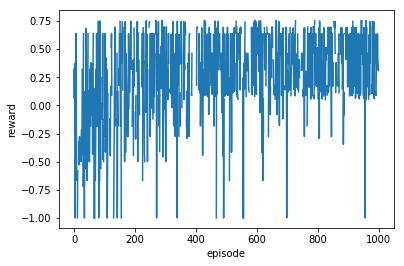

In [15]:
# Print the reward per episode (i.e. pretty bad plot)
import matplotlib.pyplot as plt

np.shape(agent.memory_longterm)[0]
num_episodes = int(0)
steps = 0.
for idx in range(np.shape(agent.memory)[0]):
    if agent.memory[idx][-1]:
        num_episodes = num_episodes + int(1)
acc_reward_idx = int(0);
acc_reward = np.zeros((num_episodes,))
for idx in range(np.shape(agent.memory)[0]):
    current_reward = agent.memory[idx][2]
    acc_reward[acc_reward_idx] = acc_reward[acc_reward_idx] + current_reward
    # acc_reward[acc_reward_idx] =  acc_reward[acc_reward_idx] + (1. if current_reward > 0 else 0.)
    steps = steps + 1.
    if agent.memory[idx][-1]:
        acc_reward[acc_reward_idx] = acc_reward[acc_reward_idx] / steps
        if acc_reward[acc_reward_idx] < 0.01 and acc_reward[acc_reward_idx] > -0.01:
            acc_reward[acc_reward_idx] = np.nan
        steps = 0.
        acc_reward_idx = acc_reward_idx + int(1)

plt.plot(acc_reward)
plt.ylabel('reward')
plt.xlabel('episode')
plt.show()

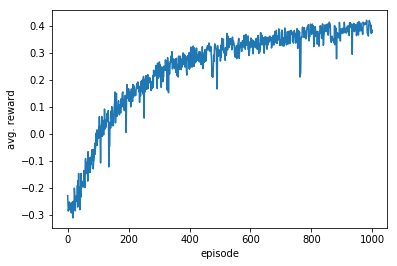

In [16]:
# Print the average reward of randomly sampled environments (much better)
import matplotlib.pyplot as plt
avg_reward_ = np.sum(avg_reward, axis=1)
plt.plot(avg_reward_[:1000] / avg_reward.shape[1])
plt.ylabel('avg. reward')
plt.xlabel('episode')
plt.show()